In [168]:
import sys
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/src/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

# from processing import PrelimAnalysis
from features.dependence import (DependenceExplore, 
                                 standardize_spatial, 
                                 standardize_temporal, 
                                 get_corr_spatial, 
                                 get_corr_temporal)

# from py_esdc.data import ESDCData
from py_esdc.data import window_xy, get_xy_indices
from py_esdc.utils import xarray2df

from ipywidgets import interact 
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.simplefilter('ignore')
from dask.diagnostics import ProgressBar
import matplotlib.cm as cm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
esdc_data = DependenceExplore()

year = '2010'
data = esdc_data.get_xr_data(year=year)
data_europe = esdc_data.get_subarea(data, area='europe')


data_russia = esdc_data.get_subarea(data, area='russia')

### Visualize: Yearly Mean

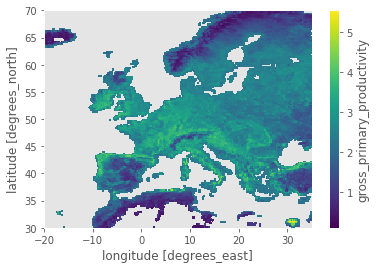

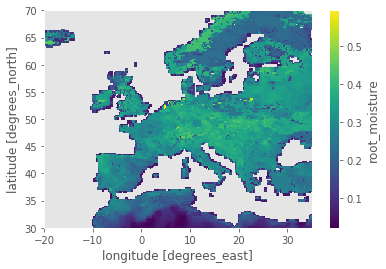

In [147]:
esdc_data.plot_yearly_mean(data_europe.gross_primary_productivity, 'gpp_europe')
esdc_data.plot_yearly_mean(data_europe.root_moisture, 'rm_europe')

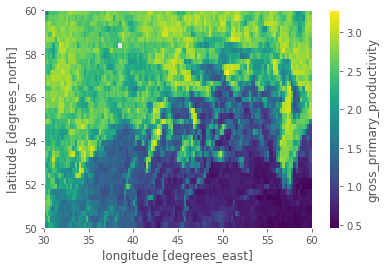

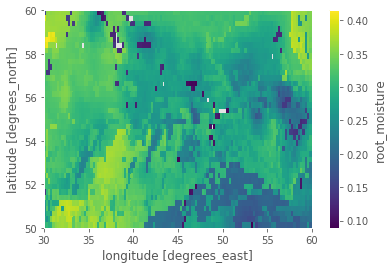

In [149]:
esdc_data.plot_yearly_mean(data_russia.gross_primary_productivity, 'gpp_russia')
esdc_data.plot_yearly_mean(data_russia.root_moisture, 'rm_russia')

### Monthly Stats

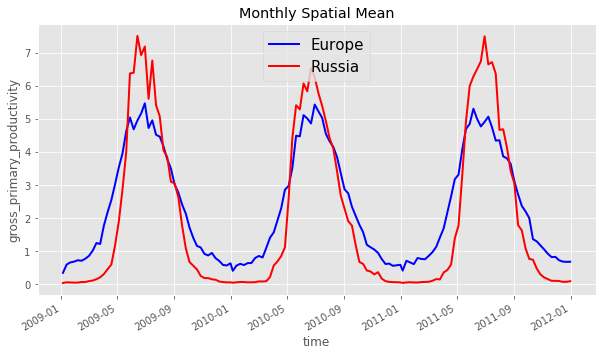

In [178]:
years = ['2009', '2010', '2011']
datasets_europe = list()
datasets_russia = list()
for iyear in years:
    esdc_data = DependenceExplore()

    data = esdc_data.get_xr_data(year=iyear)
    datasets_europe.append(esdc_data.get_subarea(data, area='europe'))


    datasets_russia.append(esdc_data.get_subarea(data, area='russia'))
    
data_europe = xr.concat(datasets_europe, dim='time')
data_russia = xr.concat(datasets_russia, dim='time')
esdc_data.plot_monthly(
    data_europe.gross_primary_productivity,
    data_russia.gross_primary_productivity, 
    stat='mean', 
    save_name=f'monthly_gpp_{iyear}')

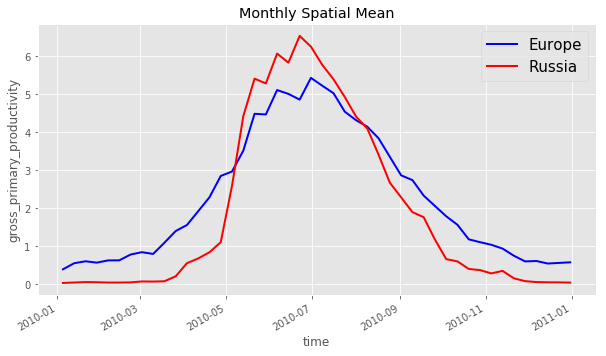

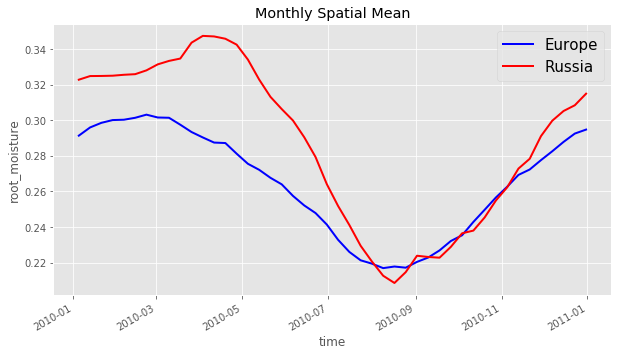

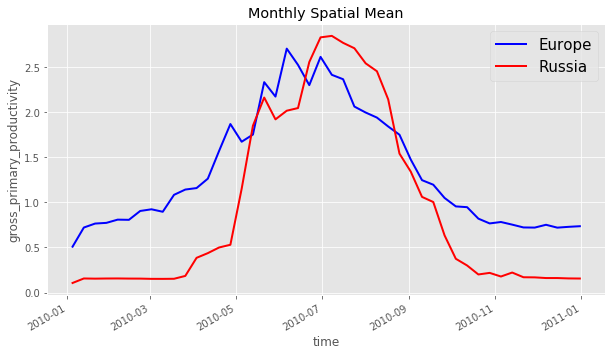

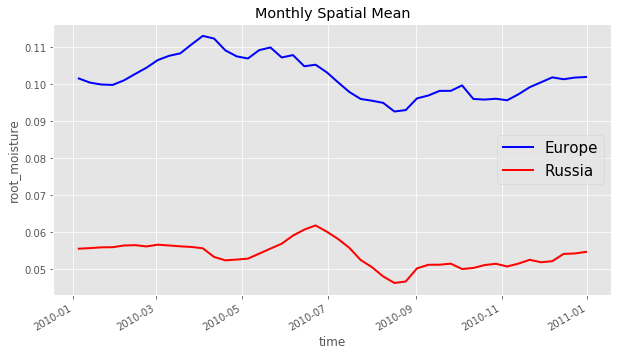

In [158]:
esdc_data = DependenceExplore()

year = '2010'
data = esdc_data.get_xr_data(year=year)
data_europe = esdc_data.get_subarea(data, area='europe')


data_russia = esdc_data.get_subarea(data, area='russia')

esdc_data.plot_monthly(
    data_europe.gross_primary_productivity,
    data_russia.gross_primary_productivity, 
    stat='mean', 
    save_name='monthly_gpp')

esdc_data.plot_monthly(
    data_europe.root_moisture,
    data_russia.root_moisture, 
    stat='mean', 
    save_name='monthly_rm')

esdc_data.plot_monthly(
    data_europe.gross_primary_productivity,
    data_russia.gross_primary_productivity, 
    stat='std', 
    save_name='monthly_gpp')

esdc_data.plot_monthly(
    data_europe.root_moisture,
    data_russia.root_moisture, 
    stat='std', 
    save_name='monthly_rm')

### Standardization

In [164]:
data_europe_st = standardize_spatial(data_europe)
data_russia_st = standardize_spatial(data_russia)

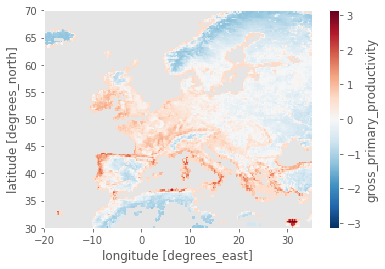

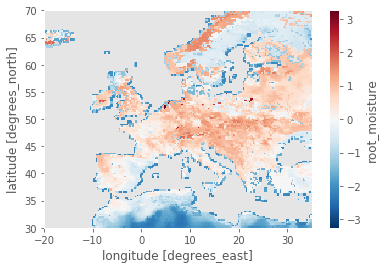

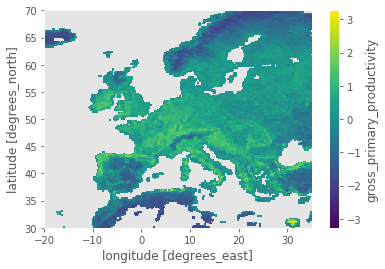

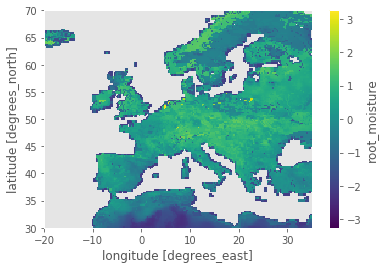

### Correlation

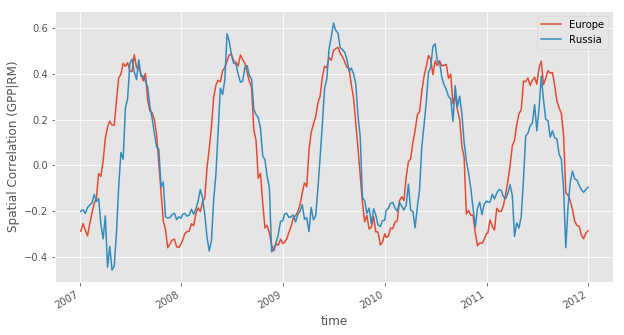

Text(0, 0.5, 'Spatial Correlation (GPP|RM)')

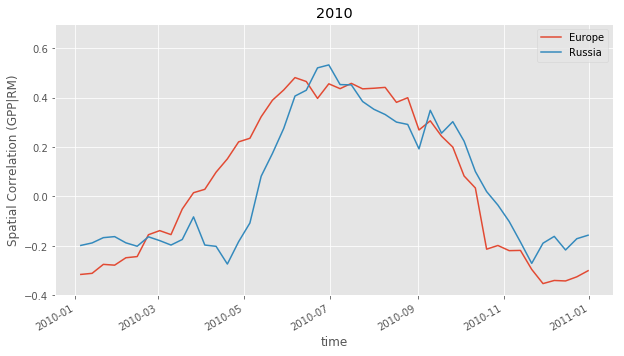

Text(0, 0.5, 'Temporal Correlation (GPP|RM)')

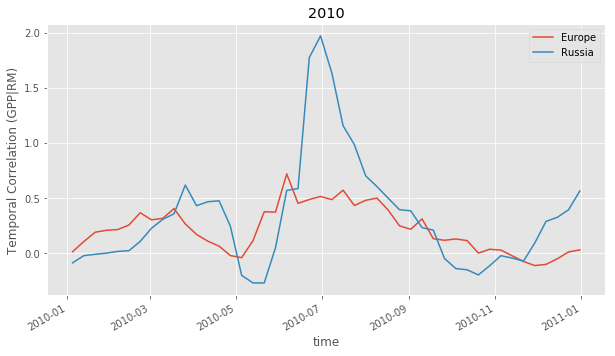

In [121]:
# Get Spatial Correlation
corr_europe = get_corr_temporal(gpp_europe_st, rm_europe_st)
corr_russia = get_corr_temporal(gpp_russia_st, rm_russia_st)

# ymax = np.max(corr_europe.max().compute(), corr_russia.max().compute())
fig, ax = plt.subplots(figsize=(10, 5))

corr_europe.plot(ax=ax, label='Europe')
corr_russia.plot(ax=ax, label='Russia')
# ax.set_ylim([-0.4, ymax])
ax.legend()
ax.set_title('2010')
ax.set_ylabel('Temporal Correlation (GPP|RM)')

ValueError: must supply at least one object to concatenate

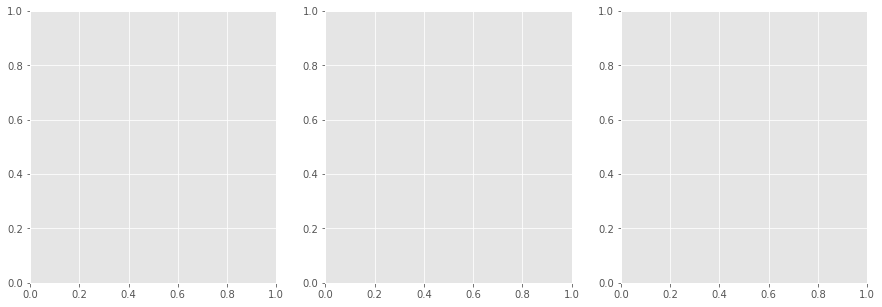

In [108]:
years = ['2009'] #, '2010', '2011']

fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)

for iyear, ax in zip(years, axs):
    
    # Extract for Europe
    gpp_sub = gpp_europe_st.sel(time=slice(iyear, iyear))
    rm_sub = rm_europe_st.sel(time=slice(iyear, iyear))
    corr_europe = get_corr_spatial(gpp_sub, rm_sub)
    
    # Extract for Russia
    gpp_sub_r = gpp_russian_st.sel(time=slice(iyear, iyear))
    rm_sub_r = rm_russian_st.sel(time=slice(iyear, iyear))
    corr_russia = get_corr_spatial(gpp_sub_r, rm_sub_r)

    corr_europe.plot(ax=ax, label='Europe')
    corr_russia.plot(ax=ax, label='Russia')
    ax.set_ylim([-0.4, 0.7])
    ax.legend()
    ax.set_title(iyear)
    ax.set_ylabel('Correlation (GPP|RM)')
    
plt.show()
fig.savefig(figure_path + f"corr_{iyear}.png")

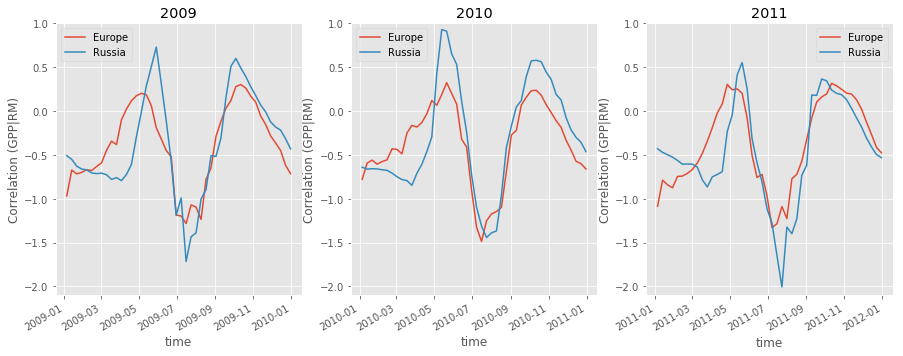

In [19]:
years = ['2009', '2010', '2011']
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)
for iyear, ax in zip(years, axs):
    # Extract for Europe
    gpp_sub = gpp_europe.sel(time=slice(iyear, iyear))
    rm_sub = rm_europe.sel(time=slice(iyear, iyear))
    corr_europe = get_corr_temporal(gpp_sub, rm_sub)
#     print(corr_europe)
#     print(corr_europe.max().compute(), corr_europe.min().compute())
    # Extract for Europe
    gpp_sub_r = gpp_russian.sel(time=slice(iyear, iyear))
    rm_sub_r = rm_russian.sel(time=slice(iyear, iyear))
    corr_russia = get_corr_temporal(gpp_sub_r, rm_sub_r)

    corr_europe.plot(ax=ax, label='Europe')
    corr_russia.plot(ax=ax, label='Russia')
    ax.legend()
    ax.set_ylim([-2.1, 1.0])
    ax.set_title(iyear)
    ax.set_ylabel('Correlation (GPP|RM)')
plt.show()
fig.savefig(figure_path + f"corr_temporal_{iyear}.png")